# Imports

In [1]:
!pip install -q transformers datasets torch accelerate scikit-learn pandas numpy matplotlib seaborn
!pip install -q sentencepiece scipy plotly

In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import time
import json
from collections import defaultdict, Counter

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    f1_score, precision_score, recall_score, cohen_kappa_score,
    matthews_corrcoef
)
from sklearn.utils import resample
from sklearn.utils.class_weight import compute_class_weight
from scipy import stats

from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding,
    EarlyStoppingCallback
)
from datasets import Dataset
import warnings
warnings.filterwarnings('ignore')

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

Using device: cuda
GPU: Tesla T4
GPU Memory: 15.83 GB


# Brief EDA

In [3]:
df_with_stance = pd.read_csv('final_dataset_with_stance.csv')
df_original = pd.read_csv('final_dataset.csv')

df = pd.merge(
    df_original,
    df_with_stance[['title', 'stance']],
    on='title',
    how='left'
)

In [4]:
print(f"Dataset shape: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")
print(f"\nMissing values:\n{df.isnull().sum()}")
print(f"\nStance distribution:")
print(df['stance'].value_counts())
print(f"\nPercentages:")
print(df['stance'].value_counts(normalize=True).round(4) * 100)

Dataset shape: (16164, 11)

Columns: ['title', 'content', 'source', 'date', 'time', 'category', 'sub-category', 'url', 'label', 'label_score', 'stance']

Missing values:
title           0
content         0
source          0
date            0
time            0
category        0
sub-category    0
url             0
label           0
label_score     0
stance          0
dtype: int64

Stance distribution:
stance
Agrees       14531
Discusses      870
Disagrees      763
Name: count, dtype: int64

Percentages:
stance
Agrees       89.90
Discusses     5.38
Disagrees     4.72
Name: proportion, dtype: float64


In [5]:
df.head()

,title,content,source,date,time,category,sub-category,url,label,label_score,stance
0,Anak Penjaga Kebersihan Masjid Lantamal 1 Bela...,Setelah dihebohkan dengan kemunculan calon tar...,posmetro-medan.com,"Oktober 19, 2019",-,Berita Viral,-,https://www.posmetro-medan.com/2019/10/anak-pe...,clickbait,1,Agrees
1,Wakil Menkeu : Kenaikan Iuran BPJS Tidak Akan ...,Jelang akhir tahun kabar kenaikan tarif iuran...,posmetro-medan.com,"Oktober 07, 2019",-,nasional,-,https://www.posmetro-medan.com/2019/10/wakil-m...,non-clickbait,0,Agrees
2,"Pendukung Jokowi Ngaku Diculik di Masjid, Ini ...",Pengurus Dewan Kemakmuran Masjid (DKM) Al-Fala...,posmetro-medan.com,"Oktober 07, 2019",-,nasional,-,https://www.posmetro-medan.com/2019/10/penduku...,clickbait,1,Agrees
3,"Sebentar Lagi, Minyak Curah Dilarang, Warga Ha...",Menteri Perdagangan Enggartiasto Lukita melara...,posmetro-medan.com,"Oktober 07, 2019",-,Berita Utama,-,https://www.posmetro-medan.com/2019/10/sebenta...,clickbait,1,Agrees
4,Ya Tuhan... Hubungan Sedarah di Sumut Meningka...,"Miris, meski dianggap tabu dalam agama maupun ...",posmetro-medan.com,"Oktober 07, 2019",-,Berita Sumut,-,https://www.posmetro-medan.com/2019/10/ya-tuha...,clickbait,1,Agrees


In [6]:
def clean_text(text):
    if pd.isna(text):
        return ""

    text = str(text)
    text = text.replace(',,', ' ')
    text = ' '.join(text.split())

    return text.strip()

df['title'] = df['title'].apply(clean_text)
df['content'] = df['content'].apply(clean_text)

df = df[(df['title'] != '') & (df['content'] != '')].copy()

df['title_length'] = df['title'].str.len()
df['content_length'] = df['content'].str.len()
df['title_word_count'] = df['title'].str.split().str.len()
df['content_word_count'] = df['content'].str.split().str.len()

print(f"\nCleaned dataset shape: {df.shape}")
print(f"\nText statistics:")
print(df[['title_length', 'content_length', 'title_word_count', 'content_word_count']].describe())


Cleaned dataset shape: (16164, 15)

Text statistics:
       title_length  content_length  title_word_count  content_word_count
count  16164.000000    16164.000000      16164.000000        16164.000000
mean      63.952178     1853.102635          9.655593          252.992081
std       14.041162     1027.498417          2.292016          139.776276
min       12.000000        3.000000          2.000000            1.000000
25%       55.000000     1222.000000          8.000000          168.000000
50%       63.000000     1648.000000          9.000000          226.000000
75%       72.000000     2185.000000         11.000000          298.000000
max      123.000000    20027.000000         19.000000         2922.000000


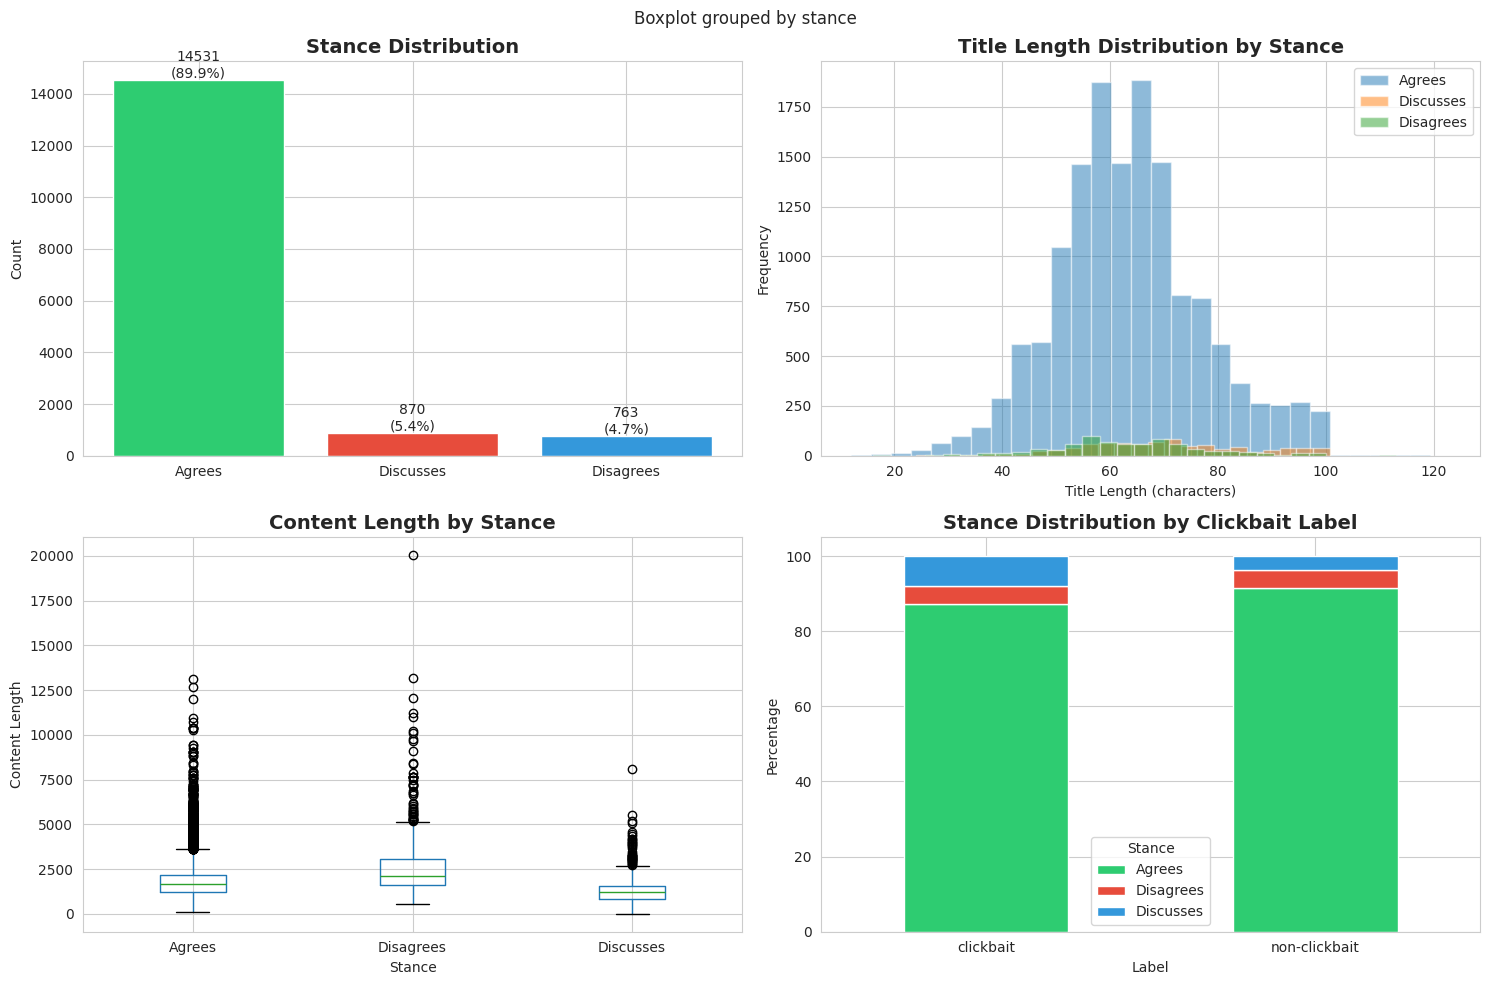

In [7]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

stance_counts = df['stance'].value_counts()
axes[0, 0].bar(stance_counts.index, stance_counts.values, color=['#2ecc71', '#e74c3c', '#3498db'])
axes[0, 0].set_title('Stance Distribution', fontsize=14, fontweight='bold')
axes[0, 0].set_ylabel('Count')
for i, v in enumerate(stance_counts.values):
    axes[0, 0].text(i, v + 100, f'{v}\n({v/len(df)*100:.1f}%)', ha='center')

for stance in df['stance'].unique():
    data = df[df['stance'] == stance]['title_length']
    axes[0, 1].hist(data, alpha=0.5, label=stance, bins=30)
axes[0, 1].set_title('Title Length Distribution by Stance', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Title Length (characters)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].legend()

df.boxplot(column='content_length', by='stance', ax=axes[1, 0])
axes[1, 0].set_title('Content Length by Stance', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Stance')
axes[1, 0].set_ylabel('Content Length')
plt.sca(axes[1, 0])
plt.xticks(rotation=0)

if 'label' in df.columns:
    label_stance = pd.crosstab(df['label'], df['stance'], normalize='index') * 100
    label_stance.plot(kind='bar', stacked=True, ax=axes[1, 1],
                     color=['#2ecc71', '#e74c3c', '#3498db'])
    axes[1, 1].set_title('Stance Distribution by Clickbait Label', fontsize=14, fontweight='bold')
    axes[1, 1].set_ylabel('Percentage')
    axes[1, 1].set_xlabel('Label')
    axes[1, 1].legend(title='Stance')
    plt.sca(axes[1, 1])
    plt.xticks(rotation=0)

plt.tight_layout()
plt.show()

In [8]:
print("=" * 50)
print("Statistical Analysis of Features by Stance")
print("=" * 50)

features = ['title_length', 'content_length', 'title_word_count', 'content_word_count']
stances = df['stance'].unique()

for feature in features:
    print(f"\n{feature.upper()}:")
    groups = [df[df['stance'] == s][feature].values for s in stances]

    f_stat, p_value = stats.f_oneway(*groups)
    print(f"  ANOVA: F={f_stat:.4f}, p-value={p_value:.4e}")

    if p_value < 0.05:
        print(f"  ✓ Significant difference found (p < 0.05)")
    else:
        print(f"  ✗ No significant difference (p >= 0.05)")

    print(f"  Means by stance:")
    for stance in stances:
        mean_val = df[df['stance'] == stance][feature].mean()
        print(f"    {stance}: {mean_val:.2f}")

Statistical Analysis of Features by Stance

TITLE_LENGTH:
  ANOVA: F=102.1500, p-value=8.2206e-45
  ✓ Significant difference found (p < 0.05)
  Means by stance:
    Agrees: 63.56
    Discusses: 70.53
    Disagrees: 63.84

CONTENT_LENGTH:
  ANOVA: F=346.6378, p-value=3.9503e-148
  ✓ Significant difference found (p < 0.05)
  Means by stance:
    Agrees: 1848.06
    Discusses: 1285.64
    Disagrees: 2596.26

TITLE_WORD_COUNT:
  ANOVA: F=95.2424, p-value=7.5616e-42
  ✓ Significant difference found (p < 0.05)
  Means by stance:
    Agrees: 9.59
    Discusses: 10.69
    Disagrees: 9.64

CONTENT_WORD_COUNT:
  ANOVA: F=325.9539, p-value=1.6620e-139
  ✓ Significant difference found (p < 0.05)
  Means by stance:
    Agrees: 252.19
    Discusses: 179.32
    Disagrees: 352.22


# Prepare Dataset

In [9]:
df_agrees = df[df['stance'] == 'Agrees']
df_disagrees = df[df['stance'] == 'Disagrees']
df_discusses = df[df['stance'] == 'Discusses']

print(f"Original distribution:")
print(f"  Agrees: {len(df_agrees):,}")
print(f"  Disagrees: {len(df_disagrees):,}")
print(f"  Discusses: {len(df_discusses):,}")

target_minority = max(len(df_disagrees), len(df_discusses)) * 3
target_majority = target_minority * 2.5

df_disagrees_balanced = resample(df_disagrees,
                                  replace=True,
                                  n_samples=target_minority,
                                  random_state=SEED,
                                  stratify=None)

df_discusses_balanced = resample(df_discusses,
                                  replace=True,
                                  n_samples=target_minority,
                                  random_state=SEED,
                                  stratify=None)

df_agrees_balanced = resample(df_agrees,
                               replace=False,
                               n_samples=int(target_majority),
                               random_state=SEED,
                               stratify=None)

df_balanced = pd.concat([df_agrees_balanced, df_disagrees_balanced, df_discusses_balanced])
df_balanced = df_balanced.sample(frac=1, random_state=SEED).reset_index(drop=True)

print(f"\nBalanced distribution:")
print(df_balanced['stance'].value_counts())
print(f"\nTotal samples: {len(df_balanced):,}")

Original distribution:
  Agrees: 14,531
  Disagrees: 763
  Discusses: 870

Balanced distribution:
stance
Agrees       6525
Discusses    2610
Disagrees    2610
Name: count, dtype: int64

Total samples: 11,745


In [11]:
def create_enhanced_input(title, content, content_length):
    if content_length > 2300:
        length_marker = "[LONG]"
    elif content_length > 1500:
        length_marker = "[MEDIUM]"
    else:
        length_marker = "[SHORT]"

    return f"{length_marker} {title} [SEP] {content}"

df_balanced['text'] = df_balanced.apply(
    lambda row: create_enhanced_input(row['title'], row['content'], row['content_length']),
    axis=1
)

label2id = {'Agrees': 0, 'Disagrees': 1, 'Discusses': 2}
id2label = {0: 'Agrees', 1: 'Disagrees', 2: 'Discusses'}
df_balanced['label_id'] = df_balanced['stance'].map(label2id)

print("Input example:")
print(df_balanced['text'].iloc[0][:200] + "...")

Input example:
[LONG] Ngeri, Bakteri Sekarang Bisa Temukan Cara untuk Kebal dari Antibiotik [SEP] diklaim kian mampu mengembangkan cara untuk mempertahankan diri dari pengaruh obat. Mereka disebut semakin kebal dan ...


In [14]:
train_df, test_df = train_test_split(
    df_balanced[['text', 'label_id', 'stance']],
    test_size=0.2,
    random_state=SEED,
    stratify=df_balanced['label_id']
)

train_df, val_df = train_test_split(
    train_df,
    test_size=0.1,
    random_state=SEED,
    stratify=train_df['label_id']
)

print(f"Split sizes:")
print(f"  Train: {len(train_df):,}")
print(f"  Val:   {len(val_df):,}")
print(f"  Test:  {len(test_df):,}")

y_train = train_df['label_id'].values
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights_dict = {i: float(weight) for i, weight in enumerate(class_weights)}

print(f"\nClass Wights:")
for class_id, weight in class_weights_dict.items():
    print(f"  {id2label[class_id]:12s}: {weight:.4f}")

Split sizes:
  Train: 8,456
  Val:   940
  Test:  2,349

Class Wights:
  Agrees      : 0.6000
  Disagrees   : 1.5001
  Discusses   : 1.5001


# Model Finetuning

In [16]:
MODELS = {
    'IndoBERT': 'indolem/indobert-base-uncased',
    "IndoRoBERTa": "cahya/roberta-base-indonesian-522M",
    'XLM-R': 'xlm-roberta-base',
    'mBERT': 'bert-base-multilingual-cased',
    'DistilmBERT': 'distilbert-base-multilingual-cased'
}

In [25]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2.0, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none', weight=self.alpha)
        pt = torch.exp(-ce_loss)
        focal_loss = ((1 - pt) ** self.gamma) * ce_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        return focal_loss

class FocalLossTrainer(Trainer):
    def __init__(self, *args, class_weights=None, use_focal_loss=True, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights
        self.use_focal_loss = use_focal_loss

    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits

        if self.use_focal_loss and self.class_weights is not None:
            loss_fct = FocalLoss(
                alpha=torch.tensor(list(self.class_weights.values())).to(model.device),
                gamma=2.0
            )
            loss = loss_fct(logits, labels)
        else:
            loss_fct = nn.CrossEntropyLoss(
                weight=torch.tensor(list(self.class_weights.values())).to(model.device)
            )
            loss = loss_fct(logits, labels)

        return (loss, outputs) if return_outputs else loss

In [29]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)

    return {
        'accuracy': accuracy_score(labels, predictions),
        'f1_macro': f1_score(labels, predictions, average='macro'),
        'f1_weighted': f1_score(labels, predictions, average='weighted'),
        'precision_macro': precision_score(labels, predictions, average='macro'),
        'recall_macro': recall_score(labels, predictions, average='macro'),
        'cohen_kappa': cohen_kappa_score(labels, predictions),
        'mcc': matthews_corrcoef(labels, predictions)
    }

def train_and_evaluate_model(model_name, model_id, train_dataset, val_dataset, test_dataset,
                            class_weights_dict, use_focal_loss=True):
    print(f"\n{'='*50}")
    print(f"Training {model_name}")
    print(f"{'='*50}")

    tokenizer = AutoTokenizer.from_pretrained(model_id)
    model = AutoModelForSequenceClassification.from_pretrained(
        model_id,
        num_labels=3,
        id2label=id2label,
        label2id=label2id
    )

    def tokenize_function(examples):
        return tokenizer(
            examples['text'],
            padding='max_length',
            truncation=True,
            max_length=512
        )

    train_tokenized = train_dataset.map(tokenize_function, batched=True)
    val_tokenized = val_dataset.map(tokenize_function, batched=True)
    test_tokenized = test_dataset.map(tokenize_function, batched=True)

    train_tokenized.set_format('torch', columns=['input_ids', 'attention_mask', 'label_id'])
    val_tokenized.set_format('torch', columns=['input_ids', 'attention_mask', 'label_id'])
    test_tokenized.set_format('torch', columns=['input_ids', 'attention_mask', 'label_id'])

    train_tokenized = train_tokenized.rename_column('label_id', 'labels')
    val_tokenized = val_tokenized.rename_column('label_id', 'labels')
    test_tokenized = test_tokenized.rename_column('label_id', 'labels')

    training_args = TrainingArguments(
        output_dir=f'./model_{model_name.lower().replace("-", "_")}',
        num_train_epochs=4,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=16,
        learning_rate=2e-5,
        weight_decay=0.01,
        warmup_steps=500,
        logging_steps=100,
        eval_strategy='steps',
        eval_steps=500,
        save_strategy='steps',
        save_steps=500,
        save_total_limit=2,
        load_best_model_at_end=True,
        metric_for_best_model='f1_macro',
        greater_is_better=True,
        fp16=torch.cuda.is_available(),
        report_to='none',
        seed=SEED
    )

    trainer = FocalLossTrainer(
        model=model,
        args=training_args,
        train_dataset=train_tokenized,
        eval_dataset=val_tokenized,
        tokenizer=tokenizer,
        data_collator=DataCollatorWithPadding(tokenizer=tokenizer),
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
        class_weights=class_weights_dict,
        use_focal_loss=use_focal_loss
    )

    start_time = time.time()
    train_result = trainer.train()
    training_time = time.time() - start_time

    test_results = trainer.evaluate(test_tokenized)
    predictions = trainer.predict(test_tokenized)
    y_pred = np.argmax(predictions.predictions, axis=1)
    y_true = test_df['label_id'].values

    start_time = time.time()
    _ = trainer.predict(test_tokenized)
    inference_time = time.time() - start_time

    model_size = sum(p.numel() for p in model.parameters()) / 1e6 * 4

    print(f"\nTraining completed!")
    print(f"  Time: {training_time/60:.2f} min")
    print(f"  Accuracy: {test_results['eval_accuracy']:.4f}")
    print(f"  F1 (macro): {test_results['eval_f1_macro']:.4f}")

    return {
        'model_name': model_name,
        'model_id': model_id,
        'test_metrics': test_results,
        'y_true': y_true,
        'y_pred': y_pred,
        'predictions': predictions,
        'training_time': training_time,
        'inference_time': inference_time,
        'model_size_mb': model_size,
        'trainer': trainer
    }

In [30]:
train_dataset = Dataset.from_pandas(train_df[['text', 'label_id']])
val_dataset = Dataset.from_pandas(val_df[['text', 'label_id']])
test_dataset = Dataset.from_pandas(test_df[['text', 'label_id']])

In [31]:
all_results = {}

for model_name, model_id in MODELS.items():
    try:
        results = train_and_evaluate_model(
            model_name,
            model_id,
            train_dataset,
            val_dataset,
            test_dataset,
            class_weights_dict,
            use_focal_loss=True
        )
        all_results[model_name] = results
    except Exception as e:
        print(f"\nError training {model_name}: {str(e)}")
        continue


Training IndoBERT


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indolem/indobert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/8456 [00:00<?, ? examples/s]

Map:   0%|          | 0/940 [00:00<?, ? examples/s]

Map:   0%|          | 0/2349 [00:00<?, ? examples/s]

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'bos_token_id': None}.


Step,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Weighted,Precision Macro,Recall Macro,Cohen Kappa,Mcc
500,0.270900,0.211567,0.757447,0.750358,0.758226,0.741609,0.788420,0.615177,0.628715
1000,0.159200,0.128935,0.869149,0.867960,0.871286,0.856961,0.893722,0.787990,0.795518
1500,0.066300,0.083553,0.934043,0.930788,0.934247,0.921656,0.941282,0.890300,0.891118
2000,0.057500,0.083749,0.939362,0.936520,0.939448,0.929428,0.945431,0.898908,0.899716
2500,0.019500,0.091079,0.946809,0.944756,0.946860,0.936259,0.954683,0.911428,0.912204
3000,0.017800,0.086343,0.947872,0.945581,0.948001,0.935586,0.957234,0.913403,0.914396
3500,0.004900,0.102279,0.951064,0.949128,0.951109,0.941227,0.958194,0.918417,0.919057
4000,0.002700,0.101370,0.953191,0.951454,0.953255,0.942067,0.962340,0.922148,0.923024



Training completed!
  Time: 20.83 min
  Accuracy: 0.9544
  F1 (macro): 0.9529

Training IndoRoBERTa


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at cahya/roberta-base-indonesian-522M and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/8456 [00:00<?, ? examples/s]

Map:   0%|          | 0/940 [00:00<?, ? examples/s]

Map:   0%|          | 0/2349 [00:00<?, ? examples/s]

Step,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Weighted,Precision Macro,Recall Macro,Cohen Kappa,Mcc
500,0.365800,0.297991,0.524468,0.533708,0.495403,0.576415,0.644748,0.332237,0.386872
1000,0.238100,0.196526,0.764894,0.760635,0.764901,0.742646,0.795759,0.624672,0.633267
1500,0.145000,0.133636,0.793617,0.798581,0.795509,0.786739,0.849340,0.679057,0.700632
2000,0.093400,0.170663,0.831915,0.828936,0.833752,0.831044,0.853202,0.727349,0.737771
2500,0.046100,0.110508,0.888298,0.885780,0.888620,0.868700,0.910955,0.818076,0.822712
3000,0.054200,0.078502,0.930851,0.928203,0.931135,0.917889,0.940323,0.885262,0.886360
3500,0.008100,0.112036,0.940426,0.937687,0.940437,0.934265,0.941288,0.899973,0.900072
4000,0.007800,0.108000,0.940426,0.937430,0.940467,0.931309,0.944157,0.900388,0.900729



Training completed!
  Time: 21.44 min
  Accuracy: 0.9451
  F1 (macro): 0.9428

Training XLM-R


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/8456 [00:00<?, ? examples/s]

Map:   0%|          | 0/940 [00:00<?, ? examples/s]

Map:   0%|          | 0/2349 [00:00<?, ? examples/s]

Step,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Weighted,Precision Macro,Recall Macro,Cohen Kappa,Mcc
500,0.379600,0.370055,0.560638,0.584195,0.560428,0.652158,0.649245,0.359781,0.418175
1000,0.221800,0.253425,0.818085,0.795134,0.811167,0.848484,0.794216,0.687877,0.697450
1500,0.130500,0.078660,0.926596,0.923080,0.926934,0.911236,0.937768,0.878629,0.880284
2000,0.096800,0.096431,0.909574,0.907058,0.910669,0.904385,0.919901,0.850398,0.854051
2500,0.058500,0.098398,0.942553,0.939850,0.942794,0.938294,0.944478,0.903717,0.904608
3000,0.047400,0.060920,0.948936,0.946717,0.949002,0.942920,0.951178,0.914364,0.914620
3500,0.018000,0.072439,0.963830,0.961836,0.963907,0.957528,0.966813,0.939378,0.939658
4000,0.019100,0.071746,0.964894,0.962951,0.964963,0.958080,0.968408,0.941195,0.941475



Training completed!
  Time: 35.05 min
  Accuracy: 0.9583
  F1 (macro): 0.9567

Training mBERT


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/8456 [00:00<?, ? examples/s]

Map:   0%|          | 0/940 [00:00<?, ? examples/s]

Map:   0%|          | 0/2349 [00:00<?, ? examples/s]

Step,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Weighted,Precision Macro,Recall Macro,Cohen Kappa,Mcc
500,0.396100,0.370724,0.627660,0.616546,0.628705,0.613486,0.650266,0.411578,0.422777
1000,0.240000,0.182816,0.713830,0.724226,0.715278,0.729416,0.780408,0.562926,0.594259
1500,0.176100,0.133208,0.812766,0.818841,0.816344,0.814137,0.862747,0.706409,0.727742
2000,0.090200,0.148294,0.865957,0.866397,0.868884,0.868197,0.884156,0.780806,0.788394
2500,0.086000,0.078104,0.905319,0.904543,0.906057,0.887406,0.931691,0.846241,0.852044
3000,0.058800,0.069601,0.929787,0.927269,0.930121,0.916445,0.940641,0.883702,0.885141
3500,0.016400,0.069753,0.936170,0.934302,0.936397,0.922513,0.949254,0.894460,0.896229
4000,0.028600,0.068893,0.942553,0.940328,0.942638,0.932349,0.949260,0.904229,0.904805



Training completed!
  Time: 26.72 min
  Accuracy: 0.9306
  F1 (macro): 0.9284

Training DistilmBERT


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/8456 [00:00<?, ? examples/s]

Map:   0%|          | 0/940 [00:00<?, ? examples/s]

Map:   0%|          | 0/2349 [00:00<?, ? examples/s]

Step,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Weighted,Precision Macro,Recall Macro,Cohen Kappa,Mcc
500,0.411100,0.356202,0.475532,0.483473,0.434304,0.541580,0.604854,0.275767,0.335126
1000,0.249600,0.308928,0.650000,0.638581,0.646994,0.705134,0.674195,0.442200,0.467500
1500,0.182100,0.149489,0.731915,0.736693,0.729066,0.724994,0.802740,0.591873,0.619163
2000,0.105500,0.134593,0.851064,0.848901,0.852136,0.835138,0.878085,0.759516,0.767432
2500,0.070400,0.120087,0.881915,0.878316,0.882583,0.862871,0.899473,0.806789,0.810151
3000,0.036700,0.105999,0.890426,0.888089,0.890860,0.869125,0.917013,0.822463,0.828360
3500,0.022900,0.123485,0.915957,0.912307,0.916296,0.904462,0.923732,0.860467,0.861994
4000,0.050200,0.107231,0.922340,0.919349,0.922561,0.908385,0.932345,0.871292,0.872520



Training completed!
  Time: 15.91 min
  Accuracy: 0.9076
  F1 (macro): 0.9052


# Model Comparison and Evalutaion

In [32]:
comparison_data = []

for model_name, results in all_results.items():
    metrics = results['test_metrics']
    comparison_data.append({
        'Model': model_name,
        'Accuracy': metrics['eval_accuracy'],
        'F1 (Macro)': metrics['eval_f1_macro'],
        'F1 (Weighted)': metrics['eval_f1_weighted'],
        'Precision': metrics['eval_precision_macro'],
        'Recall': metrics['eval_recall_macro'],
        'Cohen Kappa': metrics['eval_cohen_kappa'],
        'MCC': metrics['eval_mcc'],
        'Training Time (min)': results['training_time'] / 60,
        'Inference Time (s)': results['inference_time'],
        'Model Size (MB)': results['model_size_mb'],
        'Throughput (samples/s)': len(test_df) / results['inference_time']
    })

comparison_df = pd.DataFrame(comparison_data).round(4)

print("Model Comparison")
print(comparison_df.to_string(index=False))

Model Comparison
      Model  Accuracy  F1 (Macro)  F1 (Weighted)  Precision  Recall  Cohen Kappa    MCC  Training Time (min)  Inference Time (s)  Model Size (MB)  Throughput (samples/s)
   IndoBERT    0.9544      0.9529         0.9546     0.9431  0.9646       0.9243 0.9254              20.8286             17.8699         442.2421                131.4500
IndoRoBERTa    0.9451      0.9428         0.9452     0.9364  0.9498       0.9082 0.9085              21.4370             17.4225         503.9217                134.8256
      XLM-R    0.9583      0.9567         0.9584     0.9488  0.9658       0.9304 0.9311              35.0487             17.5388        1112.1838                133.9317
      mBERT    0.9306      0.9284         0.9308     0.9166  0.9427       0.8851 0.8866              26.7175             17.8955         711.4230                131.2618
DistilmBERT    0.9076      0.9052         0.9080     0.8887  0.9281       0.8490 0.8527              15.9088              9.2413     

In [33]:
print("\n" + "="*50)
print("Per-Class Performance")
print("="*50)

class_names = ['Agrees', 'Disagrees', 'Discusses']
per_class_results = []

for model_name, results in all_results.items():
    y_true = results['y_true']
    y_pred = results['y_pred']

    report = classification_report(y_true, y_pred, target_names=class_names,
                                   output_dict=True, zero_division=0)

    print(f"\n{model_name}:")
    print("-" * 80)
    print(classification_report(y_true, y_pred, target_names=class_names,
                               digits=4, zero_division=0))

    for class_name in class_names:
        per_class_results.append({
            'Model': model_name,
            'Class': class_name,
            'Precision': report[class_name]['precision'],
            'Recall': report[class_name]['recall'],
            'F1-Score': report[class_name]['f1-score']
        })

per_class_df = pd.DataFrame(per_class_results)


Per-Class Performance

IndoBERT:
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

      Agrees     0.9831    0.9341    0.9580      1305
   Disagrees     0.9023    0.9904    0.9443       522
   Discusses     0.9440    0.9693    0.9565       522

    accuracy                         0.9544      2349
   macro avg     0.9431    0.9646    0.9529      2349
weighted avg     0.9564    0.9544    0.9546      2349


IndoRoBERTa:
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

      Agrees     0.9645    0.9356    0.9498      1305
   Disagrees     0.9319    0.9693    0.9502       522
   Discusses     0.9130    0.9444    0.9284       522

    accuracy                         0.9451      2349
   macro avg     0.9364    0.9498    0.9428      2349
weighted avg     0.9458    0.9451    0.9452      2349


XLM-R:
--------------------

In [42]:
best_model = comparison_df.loc[comparison_df['F1 (Macro)'].idxmax(), 'Model']
best_results = all_results[best_model]

y_true = best_results['y_true']
y_pred = best_results['y_pred']

print("\n" + "="*80)
print(f"Focused Analysis on Disagrees + Clickbait - {best_model}")
print("="*80)

disagrees_mask = y_true == label2id['Disagrees']
disagrees_true = y_true[disagrees_mask]
disagrees_pred = y_pred[disagrees_mask]

disagrees_accuracy = accuracy_score(disagrees_true, disagrees_pred)
disagrees_correct = np.sum(disagrees_true == disagrees_pred)
disagrees_total = len(disagrees_true)

print(f"\nDisagrees Detection Performance:")
print(f"  Total Disagrees in test: {disagrees_total}")
print(f"  Correctly detected: {disagrees_correct} ({disagrees_accuracy:.2%})")
print(f"  Missed (False Negatives): {disagrees_total - disagrees_correct}")

disagrees_errors = disagrees_pred[disagrees_true != disagrees_pred]
if len(disagrees_errors) > 0:
    error_dist = Counter([id2label[pred] for pred in disagrees_errors])
    print(f"\nDisagrees Misclassified As:")
    for pred_class, count in error_dist.items():
        pct = count / len(disagrees_errors) * 100
        print(f"{pred_class}: {count} ({pct:.1f}%)")

print(f"\nSample Misclassified Disagrees:")
test_df_indexed = test_df.reset_index(drop=True)
missed_idx = np.where((y_true == label2id['Disagrees']) & (y_true != y_pred))[0]

for i, idx in enumerate(missed_idx[:3], 1):
    text_parts = test_df_indexed.loc[idx, 'text'].split('[SEP]')
    title = text_parts[0].replace('[LONG]', '').replace('[MEDIUM]', '').replace('[SHORT]', '').strip()
    content = text_parts[1].strip() if len(text_parts) > 1 else ''

    print(f"\nError #{i}:")
    print(f"  Title: {title[:100]}...")
    print(f"  Content: {content[:150]}...")
    print(f"  Predicted: {id2label[y_pred[idx]]}")


Focused Analysis on Disagrees + Clickbait - XLM-R

Disagrees Detection Performance:
  Total Disagrees in test: 522
  Correctly detected: 511 (97.89%)
  Missed (False Negatives): 11

Disagrees Misclassified As:
Agrees: 11 (100.0%)

Sample Misclassified Disagrees:

Error #1:
  Title: GPPU: Indonesia Minim Label Ayam Halal...
  Content: REPUBLIKA.CO.ID, BULUNGAN – Gabungan Perusahaan Pembibitan Unggas (GPPU) menyatakan meski aspek halal di peternakan ayam sudah diterapkan, label halal...
  Predicted: Agrees

Error #2:
  Title: Miris! Lama Tak Nampak, Begini Kondisi Terakhir Agung Hercules...
  Content: Agung Hercules sedang terbaring sakit. Dia terkena glioblastoma alias kanker otak stadium IV. Tubuh pedangdut pemilik hit Barbel Melayang dan Astuti i...
  Predicted: Agrees

Error #3:
  Title: Jenguk BJ Habibie, Anies: Kondisi Beliau Cukup Berat, Belum Bisa Berkomunikasi...
  Content: Gubernur DKI Jakarta Anies Baswedan menjenguk Presiden ke-3 Republik Indonesia Bacharuddin Jusuf , yang d


Threshold optimization

Optimal Threshold: 0.50
Optimal F1 for Disagrees: 0.9463
Precision: 0.9158
Recall: 0.9789


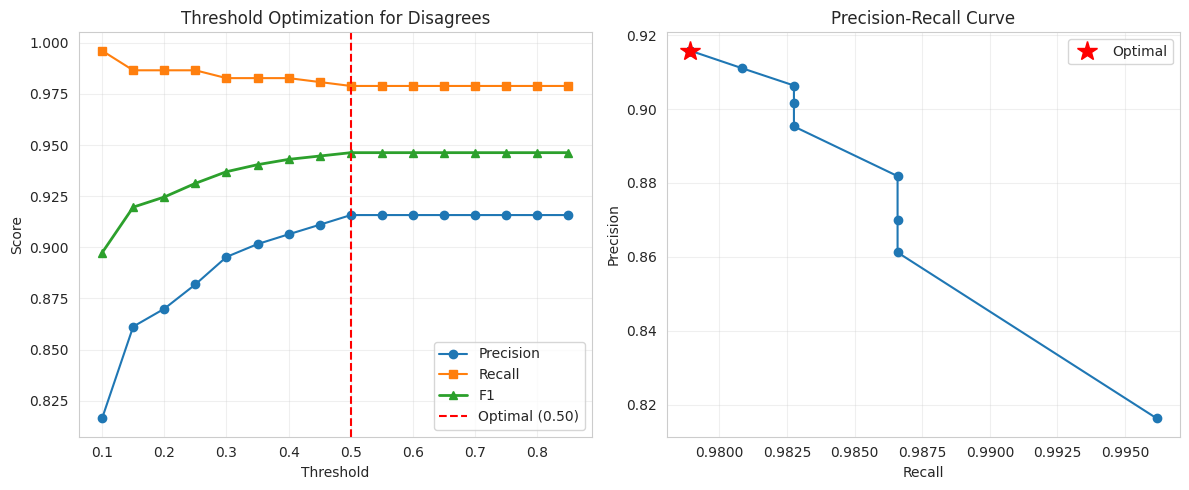


Best threshold for Disagrees classification: 0.50


In [35]:
print("\n" + "="*80)
print("Threshold optimization")
print("="*80)

logits = best_results['predictions'].predictions
probs = F.softmax(torch.tensor(logits), dim=-1).numpy()
disagrees_probs = probs[:, label2id['Disagrees']]

thresholds = np.arange(0.1, 0.9, 0.05)
results_list = []

for threshold in thresholds:
    y_pred_thresh = np.where(
        disagrees_probs > threshold,
        label2id['Disagrees'],
        y_pred
    )

    tp = np.sum((y_true == label2id['Disagrees']) & (y_pred_thresh == label2id['Disagrees']))
    fp = np.sum((y_true != label2id['Disagrees']) & (y_pred_thresh == label2id['Disagrees']))
    fn = np.sum((y_true == label2id['Disagrees']) & (y_pred_thresh != label2id['Disagrees']))

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

    results_list.append({
        'threshold': threshold,
        'precision': precision,
        'recall': recall,
        'f1': f1
    })

threshold_df = pd.DataFrame(results_list)
optimal_idx = threshold_df['f1'].idxmax()
optimal_threshold = threshold_df.loc[optimal_idx, 'threshold']
optimal_f1 = threshold_df.loc[optimal_idx, 'f1']

print(f"\nOptimal Threshold: {optimal_threshold:.2f}")
print(f"Optimal F1 for Disagrees: {optimal_f1:.4f}")
print(f"Precision: {threshold_df.loc[optimal_idx, 'precision']:.4f}")
print(f"Recall: {threshold_df.loc[optimal_idx, 'recall']:.4f}")

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(threshold_df['threshold'], threshold_df['precision'], label='Precision', marker='o')
plt.plot(threshold_df['threshold'], threshold_df['recall'], label='Recall', marker='s')
plt.plot(threshold_df['threshold'], threshold_df['f1'], label='F1', marker='^', linewidth=2)
plt.axvline(optimal_threshold, color='red', linestyle='--', label=f'Optimal ({optimal_threshold:.2f})')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Threshold Optimization for Disagrees')
plt.legend()
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(threshold_df['recall'], threshold_df['precision'], marker='o')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(alpha=0.3)

optimal_recall = threshold_df.loc[optimal_idx, 'recall']
optimal_precision = threshold_df.loc[optimal_idx, 'precision']
plt.plot(optimal_recall, optimal_precision, 'r*', markersize=15, label='Optimal')
plt.legend()

plt.tight_layout()
plt.show()

print(f"\nBest threshold for Disagrees classification: {optimal_threshold:.2f}")

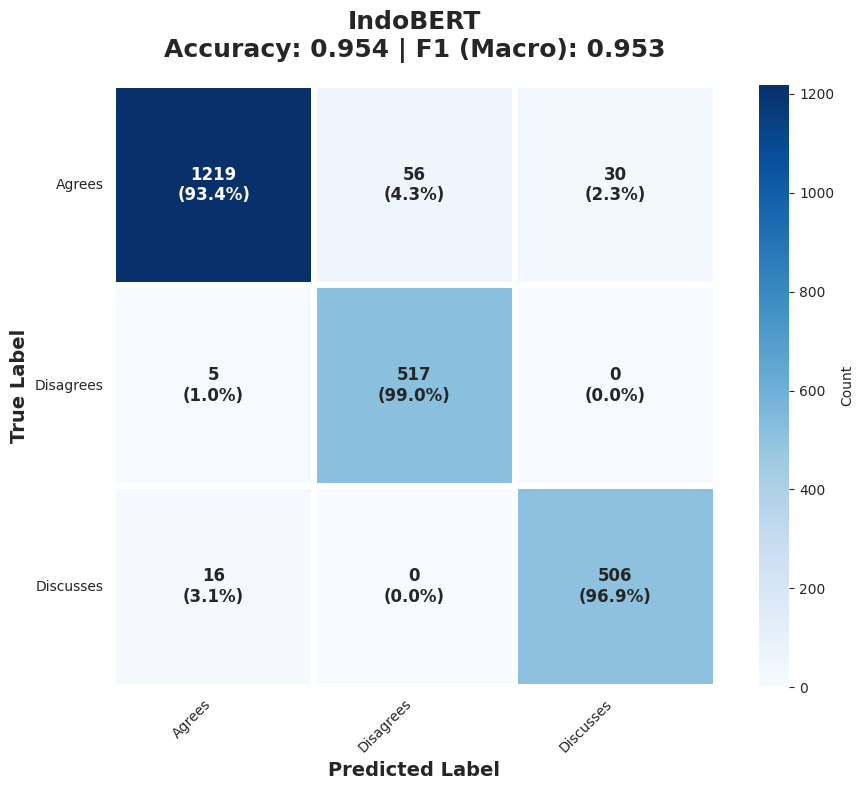

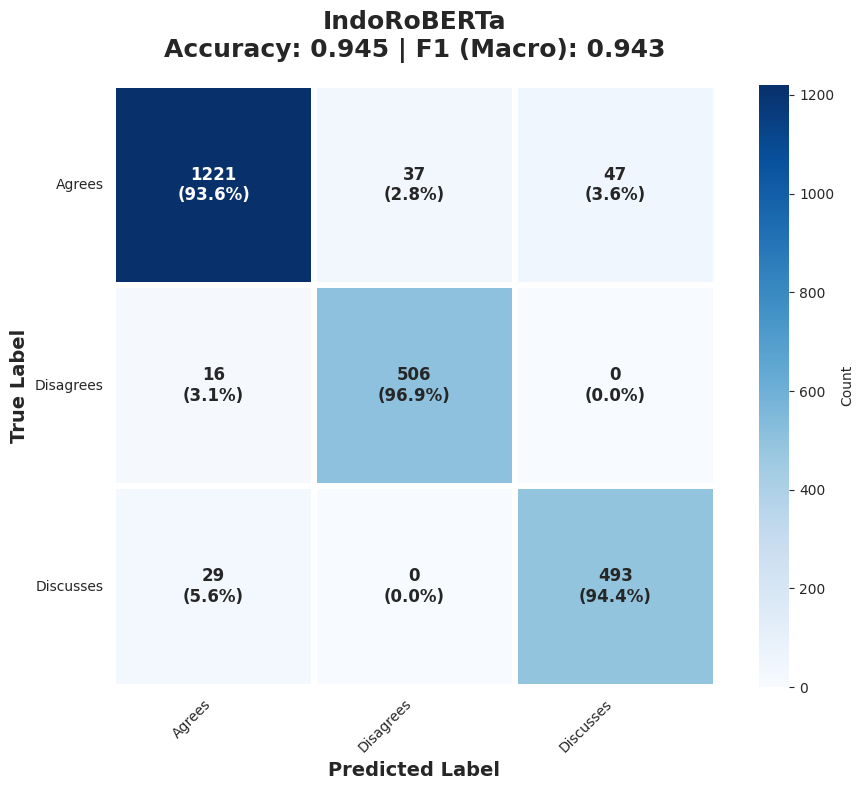

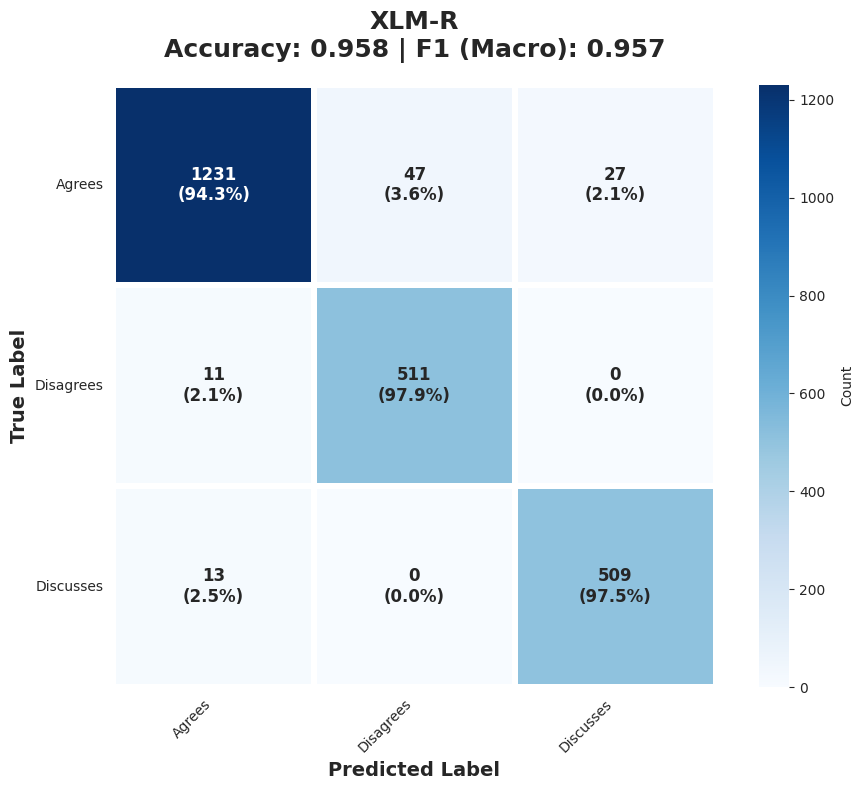

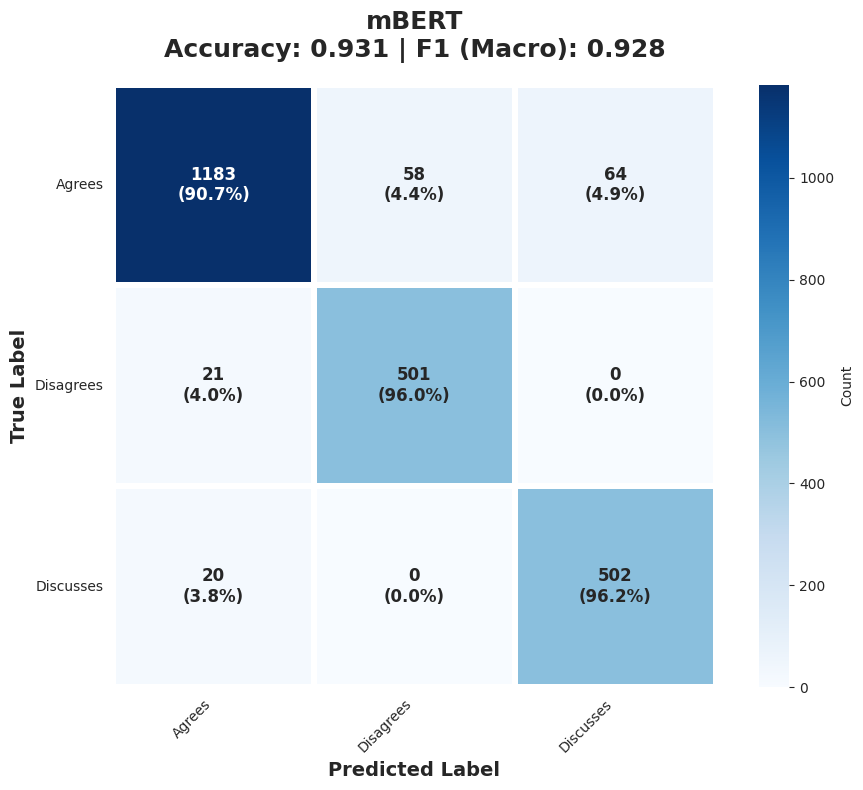

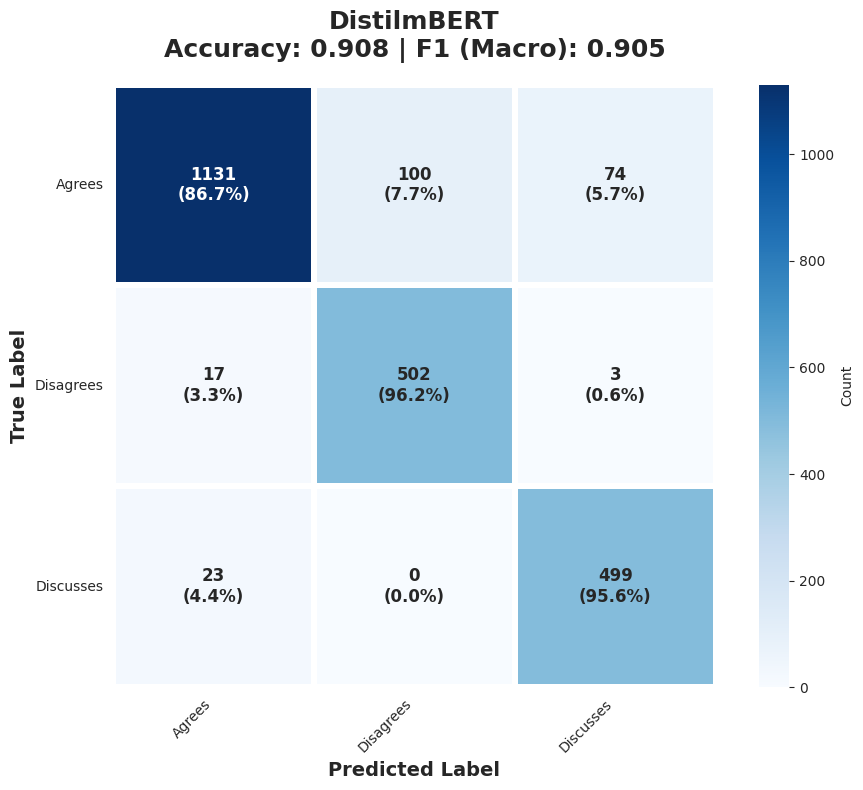

In [41]:
for model_name, results in all_results.items():
    fig, ax = plt.subplots(figsize=(10, 8))

    cm = confusion_matrix(results['y_true'], results['y_pred'])

    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
    annot_text = np.array([[f'{cm[i, j]}\n({cm_percent[i, j]:.1f}%)'
                           for j in range(len(class_names))]
                          for i in range(len(class_names))])

    sns.heatmap(cm, annot=annot_text, fmt='', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names,
                cbar_kws={'label': 'Count'},
                annot_kws={'size': 12, 'weight': 'bold'},
                linewidths=3, linecolor='white',
                vmin=0, vmax=cm.max(),
                square=True,
                ax=ax)

    accuracy = results["test_metrics"]["eval_accuracy"]
    f1_macro = results["test_metrics"]["eval_f1_macro"]

    plt.title(f'{model_name}\nAccuracy: {accuracy:.3f} | F1 (Macro): {f1_macro:.3f}',
              fontsize=18, fontweight='bold', pad=20)
    plt.ylabel('True Label', fontsize=14, fontweight='bold')
    plt.xlabel('Predicted Label', fontsize=14, fontweight='bold')

    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)

    plt.tight_layout()
    plt.show()

    print("\n" + "="*70)

In [37]:
best_f1 = comparison_df.loc[comparison_df['F1 (Macro)'].idxmax(), 'Model']
fastest = comparison_df.loc[comparison_df['Throughput (samples/s)'].idxmax(), 'Model']
smallest = comparison_df.loc[comparison_df['Model Size (MB)'].idxmin(), 'Model']

print(f"BEST OVERALL: {best_f1}")
print(f"   F1 (Macro): {comparison_df[comparison_df['Model']==best_f1]['F1 (Macro)'].values[0]:.4f}")
print(f"   Disagrees F1: {per_class_df[(per_class_df['Model']==best_f1) & (per_class_df['Class']=='Disagrees')]['F1-Score'].values[0]:.4f}")

print(f"\nFASTEST: {fastest}")
print(f"   Throughput: {comparison_df[comparison_df['Model']==fastest]['Throughput (samples/s)'].values[0]:.1f} samples/s")

BEST OVERALL: XLM-R
   F1 (Macro): 0.9567
   Disagrees F1: 0.9463

FASTEST: DistilmBERT
   Throughput: 254.2 samples/s


# Save Model

In [38]:
best_trainer = best_results['trainer']
model_save_path = f'./{best_model.lower().replace("-", "_")}_final'

best_trainer.save_model(model_save_path)
best_trainer.tokenizer.save_pretrained(model_save_path)

metrics = {
    'model_name': best_model,
    'improvements': [
        'Adaptive balancing (3x max oversample)',
        'Class weights for imbalance',
        'Focal Loss (gamma=2.0)',
        'Content length features',
        'Threshold optimization'
    ],
    'test_metrics': {k: float(v) for k, v in best_results['test_metrics'].items()},
    'optimal_threshold_disagrees': float(optimal_threshold),
    'class_weights': class_weights_dict
}

with open(f'{model_save_path}/training_metrics.json', 'w') as f:
    json.dump(metrics, f, indent=2)

Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


In [40]:
!zip -r stance_model_{best_model.lower().replace('-', '_')}.zip {model_save_path}

  adding: xlm_r_final/ (stored 0%)
  adding: xlm_r_final/training_args.bin (deflated 53%)
  adding: xlm_r_final/training_metrics.json (deflated 48%)
  adding: xlm_r_final/tokenizer_config.json (deflated 76%)
  adding: xlm_r_final/model.safetensors (deflated 23%)
  adding: xlm_r_final/config.json (deflated 51%)
  adding: xlm_r_final/sentencepiece.bpe.model (deflated 49%)
  adding: xlm_r_final/tokenizer.json (deflated 76%)
  adding: xlm_r_final/special_tokens_map.json (deflated 52%)


In [43]:
!zip -r stance_model_indobert.zip ./model_indobert

  adding: model_indobert/ (stored 0%)
  adding: model_indobert/checkpoint-4000/ (stored 0%)
  adding: model_indobert/checkpoint-4000/training_args.bin (deflated 53%)
  adding: model_indobert/checkpoint-4000/trainer_state.json (deflated 74%)
  adding: model_indobert/checkpoint-4000/tokenizer_config.json (deflated 74%)
  adding: model_indobert/checkpoint-4000/model.safetensors (deflated 7%)
  adding: model_indobert/checkpoint-4000/rng_state.pth (deflated 26%)
  adding: model_indobert/checkpoint-4000/config.json (deflated 51%)
  adding: model_indobert/checkpoint-4000/scheduler.pt (deflated 61%)
  adding: model_indobert/checkpoint-4000/optimizer.pt (deflated 13%)
  adding: model_indobert/checkpoint-4000/tokenizer.json (deflated 71%)
  adding: model_indobert/checkpoint-4000/special_tokens_map.json (deflated 42%)
  adding: model_indobert/checkpoint-4000/scaler.pt (deflated 64%)
  adding: model_indobert/checkpoint-4000/vocab.txt (deflated 52%)
  adding: model_indobert/checkpoint-4228/ (stored

In [ ]:
class StanceDetector:
    def __init__(self, model_path, use_length_markers=True):
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(f"Loading model on {self.device}")

        self.tokenizer = AutoTokenizer.from_pretrained(model_path)
        self.model = AutoModelForSequenceClassification.from_pretrained(model_path)
        self.model.to(self.device)
        self.model.eval()

        self.label2id = {'Agrees': 0, 'Disagrees': 1, 'Discusses': 2}
        self.id2label = {0: 'Agrees', 1: 'Disagrees', 2: 'Discusses'}
        self.use_length_markers = use_length_markers

    def _add_length_marker(self, content):
        if not self.use_length_markers:
            return ""

        content_len = len(content)
        if content_len > 2300:
            return "[LONG]"
        elif content_len > 1500:
            return "[MEDIUM]"
        else:
            return "[SHORT]"

    def predict(self, title, content, return_all_scores=False):
        length_marker = self._add_length_marker(content)
        text = f"{length_marker} {title} [SEP] {content[:1000]}"

        inputs = self.tokenizer(
            text,
            return_tensors='pt',
            truncation=True,
            max_length=512,
            padding=True
        )
        inputs = {k: v.to(self.device) for k, v in inputs.items()}

        with torch.no_grad():
            outputs = self.model(**inputs)
            logits = outputs.logits
            probabilities = torch.nn.functional.softmax(logits, dim=-1)

        probs = probabilities[0].cpu().numpy()
        predicted_class = np.argmax(probs)
        confidence = probs[predicted_class]

        result = {
            'stance': self.id2label[predicted_class],
            'confidence': round(float(confidence), 4)
        }

        if return_all_scores:
            result['all_scores'] = {
                self.id2label[i]: round(float(prob), 4)
                for i, prob in enumerate(probs)
            }

        return result

    def predict_batch(self, titles, contents, batch_size=16, return_all_scores=False):
        results = []

        for i in range(0, len(titles), batch_size):
            batch_titles = titles[i:i+batch_size]
            batch_contents = contents[i:i+batch_size]

            texts = []
            for title, content in zip(batch_titles, batch_contents):
                length_marker = self._add_length_marker(content)
                text = f"{length_marker} {title} [SEP] {content[:1000]}"
                texts.append(text)

            inputs = self.tokenizer(
                texts,
                return_tensors='pt',
                truncation=True,
                max_length=512,
                padding=True
            )
            inputs = {k: v.to(self.device) for k, v in inputs.items()}

            with torch.no_grad():
                outputs = self.model(**inputs)
                logits = outputs.logits
                probabilities = torch.nn.functional.softmax(logits, dim=-1)

            for j in range(len(batch_titles)):
                probs = probabilities[j].cpu().numpy()
                predicted_class = np.argmax(probs)

                result = {
                    'stance': self.id2label[predicted_class],
                    'confidence': round(float(probs[predicted_class]), 4)
                }

                if return_all_scores:
                    result['all_scores'] = {
                        self.id2label[k]: round(float(v), 4)
                        for k, v in enumerate(probs)
                    }

                results.append(result)

        return results